In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, activations
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from preprocessamento import *
from visualizacao import *


class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            activations.softmax(teacher_pred / self.temperature, axis=1),
            activations.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)



2024-08-22 15:25:21.732994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 15:25:22.488752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Carregar e preparar os dados
treino_gerador, validacao_gerador, teste_gerador, treino_df, teste_df, validacao_df = preprocessamento(
    "Datasets_csv/df_PUC.csv",
    proporcao_treino=0.6,
    proporcao_teste=0.2,
    proporcao_validacao=0.2,
    autoencoder=False
)

Found 600 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [3]:
teacher = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(128tfm.vision.configs.backbones.Transformer(

    name="teacher",
)



2024-08-22 15:25:23.939397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 15:25:24.000442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 15:25:24.000650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 2)                 2097154   
                                                                 
Total params: 2,395,906
Trainable params: 2,395,906
Non-trainable params: 0
_________________________________________________

In [5]:
student = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(2, activation='softmax')  
    ],
    name="student",
)



In [6]:
# Compilar e treinar o modelo teacher
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [7]:
checkpoint_path = 'weights_parciais/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.weights.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                  save_weights_only=True, 
                                  monitor='val_accuracy', 
                                  mode='max', 
                                  save_best_only=True, 
                                  verbose=1)

In [8]:
history = teacher.fit(
    treino_gerador,
    callbacks=[cp_callback],
    validation_data=validacao_gerador,
    epochs=30
)

Epoch 1/30


2024-08-22 15:25:24.721441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-22 15:25:25.185195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


19/19 [==============================] - ETA: 0s - loss: 3718.2788 - accuracy: 0.5450

2024-08-22 15:25:30.668076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.72500, saving model to weights_parciais/weights-improvement-01-0.73.weights.h5
19/19 [==============================] - 7s 221ms/step - loss: 3718.2788 - accuracy: 0.5450 - val_loss: 372.3802 - val_accuracy: 0.7250
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 172.0247 - accuracy: 0.8017
Epoch 2: val_accuracy improved from 0.72500 to 0.95000, saving model to weights_parciais/weights-improvement-02-0.95.weights.h5
19/19 [==============================] - 3s 145ms/step - loss: 172.0247 - accuracy: 0.8017 - val_loss: 53.3143 - val_accuracy: 0.9500
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 22.8825 - accuracy: 0.9450
Epoch 3: val_accuracy improved from 0.95000 to 0.98500, saving model to weights_parciais/weights-improvement-03-0.99.weights.h5
19/19 [==============================] - 3s 146ms/step - loss: 22.8825 - accuracy: 0.9450 - val_loss: 10.3602 - val_accuracy: 0.9850
Epoch 4/30
19/19 [======

In [9]:
teacher.evaluate(teste_gerador)

teacher.save("Modelos_keras/Modelo_Teacher.keras")
teacher.save_weights("weights_finais/Teacher.weights.h5")


3/7 [===========>..................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2024-08-22 15:26:50.861593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 0s 41ms/step - loss: 2.7121 - accuracy: 0.9850


2024-08-22 15:26:51.424686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 - 0s - loss: 2.7121 - accuracy: 0.9850 - 328ms/epoch - 47ms/step


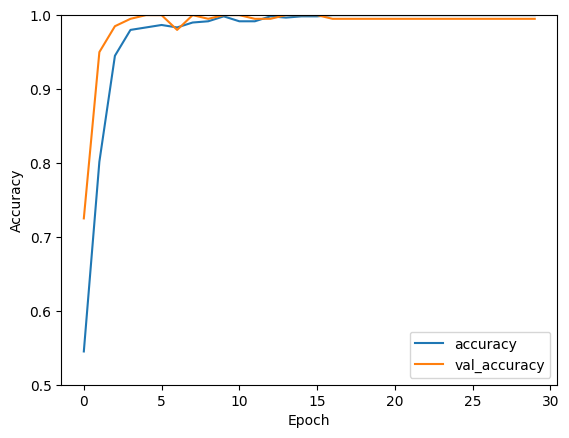

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = teacher.evaluate(teste_gerador, verbose=2)

In [11]:
predict = teacher.predict(teste_gerador)

3/7 [===========>..................] - ETA: 0s

2024-08-22 15:26:51.922327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 0s 44ms/step


In [12]:
y_verdadeiro = teste_df['classe'].values
y_binario = mapear_rotulos_binarios(y_verdadeiro) 

caminhos_imagens = teste_df['caminho_imagem'].tolist() 
imagens = carregar_e_preprocessar_imagens(caminhos_imagens)
y_predicao = teacher.predict(imagens).argmax(axis=1)

dataset = "Teste"

print(y_binario)
print(y_predicao)



7/7 [==============================] - 0s 42ms/step
[0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1
 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
[0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1
 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1]


In [13]:
plot_imagens_incorretas(y_binario, y_predicao, caminhos_imagens, teacher.name, dataset, 3) #-> Teste

In [14]:
# Carregar datasets adicionais
PUC, PUC_df = preprocessamento_dataframe_unico('Datasets_csv/df_PUC.csv')
UFPR04, UFPR04_df = preprocessamento_dataframe_unico('Datasets_csv/df_UFPR04.csv')
UFPR05, UFPR05_df = preprocessamento_dataframe_unico('Datasets_csv/df_UFPR05.csv')

# Organizar a lista de datasets
datasets = [
    ('PUC', PUC, PUC_df),
    ('UFPR04', UFPR04, UFPR04_df),
    ('UFPR05', UFPR05, UFPR05_df)
]

Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [15]:
for nome, gerador, csv in datasets:
    y = csv['classe'].values
    y = mapear_rotulos_binarios(y)

    caminhos = csv['caminho_imagem'].tolist()
    imagens = carregar_e_preprocessar_imagens(caminhos)

    predicao = teacher.predict(imagens).argmax(axis=1)

    plot_imagens_incorretas(y, predicao, caminhos, teacher.name, nome, 3)
    plot_confusion_matrix(y, predicao, ['Empty', 'Occupied'], f"Resultados/Matriz_de_confusao/{teacher.name}/{teacher.name}_vs_{nome}", f"{teacher.name} vs {nome}" )

2024-08-22 15:26:54.027394: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.
2024-08-22 15:26:54.495224: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 1s 44ms/step


2024-08-22 15:26:57.273120: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.
2024-08-22 15:26:57.752417: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 1s 44ms/step


2024-08-22 15:27:00.609050: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 1s 44ms/step


In [16]:
# Compilar e treinar o modelo distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)



In [21]:
distiller.fit(
    treino_gerador,
    validation_data=validacao_gerador,
    epochs=10
)


Epoch 1/10


2024-08-22 15:30:30.680678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


19/19 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9850

2024-08-22 15:30:34.124516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


19/19 [==============================] - 4s 190ms/step - sparse_categorical_accuracy: 0.9850 - val_sparse_categorical_accuracy: 0.9950
Epoch 2/10
19/19 [==============================] - 3s 183ms/step - sparse_categorical_accuracy: 0.9933 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
19/19 [==============================] - 4s 183ms/step - sparse_categorical_accuracy: 0.9950 - val_sparse_categorical_accuracy: 0.9900
Epoch 4/10
19/19 [==============================] - 4s 185ms/step - sparse_categorical_accuracy: 0.9933 - val_sparse_categorical_accuracy: 0.9750
Epoch 5/10
19/19 [==============================] - 4s 185ms/step - sparse_categorical_accuracy: 0.9933 - val_sparse_categorical_accuracy: 0.9800
Epoch 6/10
19/19 [==============================] - 4s 185ms/step - sparse_categorical_accuracy: 0.9950 - val_sparse_categorical_accuracy: 0.9850
Epoch 7/10
19/19 [==============================] - 3s 183ms/step - sparse_categorical_accuracy: 0.9983 - val_sparse_categorical_accura

In [24]:
distiller.evaluate(teste_gerador)


5/7 [====================>.........] - ETA: 0s - sparse_categorical_accuracy: 0.9875

2024-08-22 15:31:42.204140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 0s 27ms/step - sparse_categorical_accuracy: 0.9900


0.9900000095367432

In [25]:
# Acessar o modelo aluno da instância do Distiller
modelo_aluno = distiller.student

In [26]:
for nome, gerador, csv in datasets:
    y = csv['classe'].values
    y = mapear_rotulos_binarios(y)

    caminhos = csv['caminho_imagem'].tolist()
    imagens = carregar_e_preprocessar_imagens(caminhos)

    predicao = modelo_aluno.predict(imagens).argmax(axis=1)

    plot_imagens_incorretas(y, predicao, caminhos, modelo_aluno.name, nome, 3)
    plot_confusion_matrix(y, predicao, ['Empty', 'Occupied'], f"Resultados/Matriz_de_confusao/{modelo_aluno.name}/{modelo_aluno.name}_vs_{nome}", f"{modelo_aluno.name} vs {nome}" )

32/32 [==============================] - 1s 17ms/step
